# Импорты, воспроизводимость

In [1]:
# ========== УСТАНОВКА (опционально для чистой среды) ==========
# !pip install -q datasets scikit-learn tqdm torch torchvision torchaudio

In [2]:
# ========== ИМПОРТЫ ==========
import os, sys, random, math
from dataclasses import dataclass

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score, accuracy_score
)


In [3]:
# ========== ДИАГНОСТИКА ВЕРСИЙ ==========
print(f"Python:  {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")


Python:  3.12.3
PyTorch: 2.6.0+cu118


In [5]:
# ========== ВОСПРОИЗВОДИМОСТЬ ==========
def set_global_seed(seed: int = 42) -> None:
    """Фиксирует ГСЧ для повторяемых результатов (Python/NumPy/PyTorch)."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_global_seed(42)


In [6]:
# ========== УСТРОЙСТВО И ДЕТЕРМИНИЗМ ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if torch.cuda.is_available():
    # Детерминизм на CUDA (чуть медленнее, но стабильнее)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # При необходимости:
    # torch.use_deterministic_algorithms(True)  # может бросать исключения на недетерм. операциях


Device: cuda


### Загружаем датасет IMDB и проверяем распределение классов

В этом практикуме мы будем использовать **IMDB** — классический датасет отзывов о фильмах.

- Каждый пример состоит из текста отзыва и метки (`0` — негативный отзыв, `1` — позитивный отзыв).  
- Набор данных поделен на два сплита: `train` (для обучения модели) и `test` (для финальной проверки).  
- Мы будем решать задачу **бинарной классификации**: научимся предсказывать тональность текста (положительный или отрицательный отзыв).  
- По ходу эксперимента мы:
  1. Загрузим и посмотрим распределение классов.  
  2. Сделаем подготовку данных для модели.  
  3. Построим простую модель на PyTorch.  
  4. Посчитаем и сравнивать разные метрики качества.  
  5. Разберём, как метрики меняются при изменении порога классификации.


In [7]:
# ========== ДАННЫЕ: загрузка IMDB и проверка баланса ==========
from datasets import load_dataset
from collections import Counter

DATA_CACHE_DIR = "./data"  # куда кэшируется датасет локально (ускоряет повторные запуски)
raw_ds = load_dataset("imdb", cache_dir=DATA_CACHE_DIR)  # скачает при первом запуске, дальше читает из кэша
print(raw_ds)  # быстрый обзор: какие сплиты есть и их размер


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [8]:
# ========== БЫСТРЫЙ ПРОСМОТР ПРИМЕРОВ ==========
# В IMDB метка: 0 = негатив, 1 = позитив (важно помнить, какой класс "позитивный")
for i in range(2):
    ex = raw_ds["train"][i]
    # Показываем начало текста, чтобы понимать формат сырых данных
    print(f"label={ex['label']}  text={ex['text'][:500].replace('\n',' ')}...")


label=0  text=I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent...
label=0  text="I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes 

In [9]:
# ========== РАСПРЕДЕЛЕНИЕ МЕТОК ==========
def split_stats(ds_split, name="split"):
    """
    Печатаем размер и доли классов. Это критично для интерпретации метрик:
    - при сильном дисбалансе Accuracy может быть обманчиво высокой,
      поэтому дополнительно смотрим Precision/Recall.
    """
    n = len(ds_split)
    cnt = Counter(ds_split["label"])  # считаем частоты 0/1
    pos = cnt.get(1, 0)
    neg = cnt.get(0, 0)
    pos_ratio = pos / n if n else float("nan")
    print(f"[{name}] size={n}, negatives={neg}, positives={pos}, pos_ratio={pos_ratio:.2f}")

# Проверим оба сплита — важно, чтобы распределение train и test было сопоставимым
split_stats(raw_ds["train"], name="train")
split_stats(raw_ds["test"],  name="test")


[train] size=25000, negatives=12500, positives=12500, pos_ratio=0.50
[test] size=25000, negatives=12500, positives=12500, pos_ratio=0.50


# Токенизация и словарь (без предобученных моделей по типу семейства BeRT) ===
Задача: превратить текст (строки) в последовательности числовых идентификаторов (индексы слов).

План:
1) простая токенизация (разбиение на слова),
2) подсчёт частот слов ТОЛЬКО по train-сплиту,
3) построение словаря (слово -> индекс), резерв индекса 0 под <unk>,
4) функции encode/decode,
5) понятные проверки: топ слов, превью текста, (слово,индекс), доля <unk>, покрытие словарём.

In [10]:
# ========== ТОКЕНИЗАЦИЯ И ПОСТРОЕНИЕ СЛОВАРЯ (train-only, избегаем data leakage) ==========

from collections import Counter as TokenFrequencyCounter
import re
import numpy as np

# --- Гиперпараметры словаря ---
MIN_TOKEN_FREQUENCY: int = 2        # токены с частотой < MIN_TOKEN_FREQUENCY маппятся в <unk>
MAX_VOCABULARY_SIZE: int = 30_000   # верхняя граница числа токенов (без учёта спец-токенов), отсортированных по частоте

def simple_tokenize_imdb(review_text: str) -> list[str]:
    """
    Мини-токенизатор под IMDB:
    1) Нормализуем HTML-разметку: <br>, <br/>, <br /> → пробел.
    2) Приводим к нижнему регистру и обрезаем крайние пробелы.
    3) Разделяем по пробельным символам.
    """
    review_text = re.sub(r"<br\s*/?>", " ", review_text, flags=re.IGNORECASE)
    return review_text.lower().strip().split()

# --- Частоты считаем ТОЛЬКО на TRAIN (без утечки валидации/теста) ---
token_frequency_counter: TokenFrequencyCounter[str] = TokenFrequencyCounter()
for train_example in raw_ds["train"]:
    tokens_in_example = simple_tokenize_imdb(train_example["text"])
    token_frequency_counter.update(tokens_in_example)

# --- Фильтрация и усечение словаря по частоте ---
filtered_token_items: list[tuple[str, int]] = [
    (token, count) for token, count in token_frequency_counter.items()
    if count >= MIN_TOKEN_FREQUENCY
]
filtered_token_items.sort(key=lambda pair: pair[1], reverse=True)
top_token_items: list[tuple[str, int]] = filtered_token_items[:MAX_VOCABULARY_SIZE]

# --- Отображения: string→index (stoi) и index→string (itos), <unk>=0 ---
STRING_TO_INDEX: dict[str, int] = {"<unk>": 0}
for running_index, (token, _) in enumerate(top_token_items, start=1):
    STRING_TO_INDEX[token] = running_index

INDEX_TO_STRING: dict[int, str] = {index: token for token, index in STRING_TO_INDEX.items()}

print(f"[Словарь] размер (включая <unk>): {len(STRING_TO_INDEX)}")
print("[Словарь] первые 20 ключей:", list(STRING_TO_INDEX.keys())[:50])


[Словарь] размер (включая <unk>): 30001
[Словарь] первые 20 ключей: ['<unk>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i', 'this', 'it', 'that', 'was', 'as', 'for', 'with', 'but', 'on', 'movie', 'his', 'not', 'are', 'film', 'you', 'have', 'he', 'be', 'at', 'one', 'by', 'an', 'they', 'all', 'from', 'who', 'like', 'so', 'just', 'or', "it's", 'has', 'her', 'about', 'if', 'some', 'what', 'out', 'there', 'when', 'very']


In [11]:
# ========== КОДИРОВАНИЕ/ДЕКОДИРОВАНИЕ (OOV → 0=<unk>) ==========

def encode_text_to_token_ids(review_text: str) -> np.ndarray:
    """
    Строка → массив индексов словаря (np.int64).
    Неизвестные токены (OOV) маппятся в 0 (<unk>).
    """
    token_list = simple_tokenize_imdb(review_text)
    if not token_list:
        return np.array([], dtype=np.int64)
    token_id_sequence = [STRING_TO_INDEX.get(token, 0) for token in token_list]
    return np.array(token_id_sequence, dtype=np.int64)

def decode_token_ids_to_pairs(token_id_sequence: np.ndarray, max_tokens_to_show: int = 20) -> list[tuple[str, int]]:
    """
    Диагностика: вернуть первые max_tokens_to_show пар (токен|'<unk>', индекс).
    Удобно контролировать долю <unk> и артефакты токенизации.
    """
    preview_pairs: list[tuple[str, int]] = []
    for token_id in token_id_sequence[:max_tokens_to_show]:
        int_token_id = int(token_id)
        preview_pairs.append((INDEX_TO_STRING.get(int_token_id, "<unk>"), int_token_id))
    return preview_pairs


In [12]:
# ========== ДЕМО-ПРОВЕРКА: известный токен + OOV-токен ==========

most_frequent_known_token: str = top_token_items[0][0] if top_token_items else "the"
intentionally_oov_token: str = "supercalifragilisticexpialidocious"  # заведомо OOV
demo_token_ids: np.ndarray = encode_text_to_token_ids(
    f"{most_frequent_known_token} {intentionally_oov_token}"
)
print("[Демо] пары (токен, индекс):", decode_token_ids_to_pairs(demo_token_ids, max_tokens_to_show=5))
# Ожидание: второй элемент — ('<unk>', 0)


[Демо] пары (токен, индекс): [('the', 1), ('<unk>', 0)]


In [14]:
# ========== ДИАГНОСТИКА НА РЕАЛЬНОМ ПРИМЕРЕ И ДОЛЯ <unk> ==========

train_example_0 = raw_ds["train"][0]
encoded_token_ids: np.ndarray = encode_text_to_token_ids(train_example_0["text"])

unknown_token_count: int = int((encoded_token_ids == 0).sum())
unknown_token_ratio: float = (
    unknown_token_count / len(encoded_token_ids) if len(encoded_token_ids) > 0 else 0.0
)

print(f"[Пример] длина последовательности: {len(encoded_token_ids)}")
print(f"[Пример] <unk>: {unknown_token_count} шт. ({unknown_token_ratio:.2%} от длины)")
print("[Пример] первые 25 пар (токен, индекс):", decode_token_ids_to_pairs(encoded_token_ids, max_tokens_to_show=50))


[Пример] длина последовательности: 285
[Пример] <unk>: 10 шт. (3.51% от длины)
[Пример] первые 25 пар (токен, индекс): [('i', 8), ('rented', 1494), ('i', 8), ('am', 222), ('<unk>', 0), ('from', 33), ('my', 53), ('video', 436), ('store', 1503), ('because', 74), ('of', 4), ('all', 32), ('the', 1), ('controversy', 9787), ('that', 11), ('surrounded', 3484), ('it', 10), ('when', 48), ('it', 10), ('was', 12), ('first', 79), ('released', 700), ('in', 7), ('1967.', 26782), ('i', 8), ('also', 80), ('heard', 508), ('that', 11), ('at', 27), ('first', 79), ('it', 10), ('was', 12), ('seized', 26783), ('by', 29), ('u.s.', 2415), ('customs', 14126), ('if', 43), ('it', 10), ('ever', 122), ('tried', 737), ('to', 5), ('enter', 2611), ('this', 9), ('country,', 4222), ('therefore', 1911), ('being', 97), ('a', 2), ('fan', 373), ('of', 4), ('films', 128)]


In [15]:
# ========== ПОКРЫТИЕ СЛОВАРЁМ (средняя доля известных токенов, train/test) ==========

def estimate_vocabulary_coverage(
    dataset_split, 
    num_random_samples: int = 500, 
    rng_seed: int = 42
) -> float:
    """
    Средняя доля известных токенов (id != 0) в случайной подвыборке из split.
    Возвращает число в [0, 1] или NaN, если валидных примеров нет.
    """
    random_number_generator = np.random.default_rng(rng_seed)
    total_examples: int = len(dataset_split)
    if total_examples == 0:
        return float("nan")

    sampled_indices = random_number_generator.choice(
        total_examples, size=min(num_random_samples, total_examples), replace=False
    )

    known_token_ratios: list[float] = []
    for sampled_index in sampled_indices:
        token_id_sequence = encode_text_to_token_ids(dataset_split[int(sampled_index)]["text"])
        if len(token_id_sequence) == 0:
            continue
        per_example_known_ratio = 1.0 - (token_id_sequence == 0).sum() / len(token_id_sequence)
        known_token_ratios.append(float(per_example_known_ratio))

    return float(np.mean(known_token_ratios)) if known_token_ratios else float("nan")

train_known_ratio_mean: float = estimate_vocabulary_coverage(raw_ds["train"])
test_known_ratio_mean: float  = estimate_vocabulary_coverage(raw_ds["test"])
print(f"[Покрытие] TRAIN: {train_known_ratio_mean:.2%} | TEST: {test_known_ratio_mean:.2%}")
print("Примечание: тестовое покрытие обычно ниже, т.к. словарь строился по train (встречаются новые слова).")


[Покрытие] TRAIN: 94.19% | TEST: 93.24%
Примечание: тестовое покрытие обычно ниже, т.к. словарь строился по train (встречаются новые слова).


# Dataset + DataLoader с collate_fn для текстов разной длины
Что делаем в этой ячейке:
1) Кодируем тексты из сплитов в последовательности индексов (используем encode из предыдущей ячейки).
2) Делаем из исходного train стратифицированное разбиение на train/val (например, 80/20).
3) Создаём Dataset-классы для train/val/test.
4) Пишем collate_fn (сборка батча без паддинга: "лента токенов" + offsets).
5) Создаём DataLoader'ы и показываем формы батчей, чтобы было наглядно.


In [16]:
# Кодируем тексты один раз: сырой текст -> последовательность индексов словаря.
# Так не тратим время на повторное кодирование в каждой эпохе.
import numpy as np

encoded_train_texts = [
    encode_text_to_token_ids(example["text"])   # np.ndarray[int64] формы (seq_len,)
    for example in raw_ds["train"]
]
train_labels_vector = np.array(
    [int(example["label"]) for example in raw_ds["train"]],  # метки 0/1
    dtype=np.int64
)

encoded_test_texts = [
    encode_text_to_token_ids(example["text"])
    for example in raw_ds["test"]
]
test_labels_vector = np.array(
    [int(example["label"]) for example in raw_ds["test"]],
    dtype=np.int64
)

print("[Кодирование] TRAIN примеров:", len(encoded_train_texts))
print("[Кодирование] TEST  примеров:", len(encoded_test_texts))


[Кодирование] TRAIN примеров: 25000
[Кодирование] TEST  примеров: 25000


In [17]:
# Разбиваем TRAIN на TRAIN/VAL с сохранением пропорций классов.
# Сид фиксируем до создания сплиттера: разбиение будет повторяемым.
from sklearn.model_selection import StratifiedShuffleSplit

RNG_SEED = 42
set_global_seed(RNG_SEED)  # единый вызов: Python/NumPy/PyTorch

validation_fraction = 0.20
stratified_splitter = StratifiedShuffleSplit(
    n_splits=1,                    # одно разбиение (~80/20)
    test_size=validation_fraction,
    random_state=RNG_SEED
)

# X-заглушка: реальные признаки здесь не нужны, стратификация идёт по y.
train_index_array, val_index_array = next(
    stratified_splitter.split(np.zeros(len(train_labels_vector)), train_labels_vector)
)

# Индексируем уже закодированные последовательности и метки.
encoded_texts_train_split = [encoded_train_texts[i] for i in train_index_array]
labels_train_split        =  train_labels_vector[train_index_array]

encoded_texts_val_split   = [encoded_train_texts[i] for i in val_index_array]
labels_val_split          =  train_labels_vector[val_index_array]

print("[Разбиение] TRAIN:", len(encoded_texts_train_split))
print("[Разбиение] VAL:  ", len(encoded_texts_val_split))
print("[Разбиение] TEST: ", len(encoded_test_texts))

def print_class_balance(split_name: str, labels: np.ndarray) -> None:
    num_negative = int((labels == 0).sum())
    num_positive = int((labels == 1).sum())
    total = max(1, num_negative + num_positive)
    print(f"  [{split_name}] 0: {num_negative} | 1: {num_positive} | доля_позитивного={num_positive/total:.3f}")

print_class_balance("TRAIN", labels_train_split)
print_class_balance("VAL",   labels_val_split)
print_class_balance("TEST",  test_labels_vector)


[Разбиение] TRAIN: 20000
[Разбиение] VAL:   5000
[Разбиение] TEST:  25000
  [TRAIN] 0: 10000 | 1: 10000 | доля_позитивного=0.500
  [VAL] 0: 2500 | 1: 2500 | доля_позитивного=0.500
  [TEST] 0: 12500 | 1: 12500 | доля_позитивного=0.500


In [18]:
# Dataset-обёртка: соглашение PyTorch — данные должны поддерживать __len__ и __getitem__.
# Имя "TextDataset" показывает, что объект инкапсулирует корпус текстов + метки и отдаёт элементы по индексу.
# Такой интерфейс сразу дружит с DataLoader и упрощает замену источника данных (файлы, БД, кэш и т.д.).
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts: list[np.ndarray], labels: np.ndarray):
        assert len(texts) == len(labels), "Длины texts и labels должны совпадать."
        self.texts = texts          # список последовательностей индексов, длины могут отличаться
        self.labels = labels        # np.ndarray[int64] с 0/1

    def __len__(self) -> int:
        return len(self.texts)      # позволяет DataLoader знать размер датасета

    def __getitem__(self, sample_index: int):
        # Возвращаем элементарный образец: последовательность индексов и целевую метку.
        token_id_sequence_np = self.texts[sample_index]   # np.ndarray[int64] формы (seq_len,)
        label_int = int(self.labels[sample_index])        # приводим к python int
        return token_id_sequence_np, label_int

train_dataset = TextDataset(encoded_texts_train_split, labels_train_split)
val_dataset   = TextDataset(encoded_texts_val_split,   labels_val_split)
test_dataset  = TextDataset(encoded_test_texts,        test_labels_vector)

print("[Dataset] len(train) =", len(train_dataset))
print("[Dataset] len(val)   =", len(val_dataset))
print("[Dataset] len(test)  =", len(test_dataset))


[Dataset] len(train) = 20000
[Dataset] len(val)   = 5000
[Dataset] len(test)  = 25000


In [19]:
# ---------------------------
# 4) collate_fn: собираем батч без паддинга (concatenation + offsets)
# ---------------------------
# Склеиваем индексы всех текстов батча в один 1D-вектор concatenated_token_ids,
# а в sequence_start_offsets храним начало каждого текста внутри этого вектора.
def collate_to_bag(batch):
    """
    batch: список из N элементов [(np.ndarray токенов, метка), ...]
    Возвращает:
      concatenated_token_ids : LongTensor[sum_len] — все токены батча подряд
      sequence_start_offsets : LongTensor[N]       — начало каждого текста в concatenated_token_ids
      labels                 : LongTensor[N]       — метки (0/1) для каждого текста
    """
    labels_list = []
    sequence_start_offsets_list = [0]
    pieces = []
    running_total = 0

    for token_ids_np, y in batch:
        t = torch.as_tensor(token_ids_np, dtype=torch.long)
        pieces.append(t)
        labels_list.append(int(y))
        running_total += int(t.numel())
        sequence_start_offsets_list.append(running_total)

    concatenated_token_ids = torch.cat(pieces, dim=0) if pieces else torch.empty(0, dtype=torch.long)
    sequence_start_offsets = torch.tensor(sequence_start_offsets_list[:-1], dtype=torch.long)
    labels = torch.tensor(labels_list, dtype=torch.long)
    return concatenated_token_ids, sequence_start_offsets, labels


In [20]:
# DataLoader’ы. Для повторяемого shuffle на TRAIN передаём явный генератор с сидом.
set_global_seed(RNG_SEED)  # ноутбуки часто запускают ячейки вразнобой, повторяем фиксацию

BATCH_SIZE = 256                               # под CPU обычно 64–128; под GPU 256 часто ок
torch_shuffle_generator = torch.Generator().manual_seed(RNG_SEED)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,                 # порядок примеров внутри эпохи перемешивается одинаково при каждом запуске
    collate_fn=collate_to_bag,
    num_workers=0,
    generator=torch_shuffle_generator,  # фиксируем последовательность батчей
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_to_bag,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_to_bag,
    num_workers=0,
)

print(f"[DataLoader] train/val/test готовы; batch_size = {BATCH_SIZE}")


[DataLoader] train/val/test готовы; batch_size = 256


In [21]:
# ---------------------------
# 6) Наглядная проверка форм батчей (по одному батчу из каждого лоадера)
# ---------------------------
def show_batch_shapes(name, loader):
    concatenated_token_ids_ex, sequence_start_offsets_ex, labels_ex = next(iter(loader))
    print(f"\n[{name}] формы первого батча:")
    print("  concatenated_token_ids.shape:", tuple(concatenated_token_ids_ex.shape), " ← общая длина токенов (1D)")
    print("  sequence_start_offsets.shape:", tuple(sequence_start_offsets_ex.shape), " ← по одному начальному индексу на текст")
    print("  labels.shape:                ", tuple(labels_ex.shape),                " ← по одной метке на текст")

show_batch_shapes("TRAIN", train_loader)
show_batch_shapes("VAL",   val_loader)
show_batch_shapes("TEST",  test_loader)


[TRAIN] формы первого батча:
  concatenated_token_ids.shape: (64895,)  ← общая длина токенов (1D)
  sequence_start_offsets.shape: (256,)  ← по одному начальному индексу на текст
  labels.shape:                 (256,)  ← по одной метке на текст

[VAL] формы первого батча:
  concatenated_token_ids.shape: (64182,)  ← общая длина токенов (1D)
  sequence_start_offsets.shape: (256,)  ← по одному начальному индексу на текст
  labels.shape:                 (256,)  ← по одной метке на текст

[TEST] формы первого батча:
  concatenated_token_ids.shape: (57721,)  ← общая длина токенов (1D)
  sequence_start_offsets.shape: (256,)  ← по одному начальному индексу на текст
  labels.shape:                 (256,)  ← по одной метке на текст


# Простейшая модель (EmbeddingBag → Linear) + обучение и метрики на валидации
Что делаем:
- создаём модель, которая преобразует последовательность слов в один вектор (среднее эмбеддингов), а затем линейным слоем предсказывает "насколько текст позитивный" (логит).
- обучаем несколько эпох на train_loader.
- после каждой эпохи считаем метрики на val_loader (Accuracy/Precision/Recall/F1 при пороге 0.5).

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class SentimentBagModel(nn.Module):
    """EmbeddingBag(mode='mean') → усреднённый вектор текста → Linear → логит."""
    def __init__(self, vocab_size: int, emb_dim: int):
        super().__init__()
        self.emb = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode='mean')
        self.fc  = nn.Linear(emb_dim, 1)

    def forward(self, concatenated_token_ids: torch.Tensor, sequence_start_offsets: torch.Tensor) -> torch.Tensor:
        x = self.emb(concatenated_token_ids, sequence_start_offsets)  # [batch, emb_dim]
        logits = self.fc(x).squeeze(1)                                # [batch]
        return logits  # под BCEWithLogitsLoss

def train_one_epoch(model, loader, optimizer, criterion, device) -> float:
    model.train()
    total_loss, total_examples = 0.0, 0
    for concatenated_token_ids, sequence_start_offsets, labels in tqdm(loader, desc="train", leave=False):
        concatenated_token_ids = concatenated_token_ids.to(device)
        sequence_start_offsets = sequence_start_offsets.to(device)
        labels_f = labels.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model(concatenated_token_ids, sequence_start_offsets)
        loss = criterion(logits, labels_f)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        total_loss += float(loss.item()) * bs
        total_examples += bs
    return total_loss / max(1, total_examples)

@torch.no_grad()
def evaluate_on_loader(model, loader, device, threshold: float, criterion, name: str = "VAL"):
    model.eval()
    total_loss, total_examples = 0.0, 0
    all_probs, all_true = [], []
    for concatenated_token_ids, sequence_start_offsets, labels in tqdm(loader, desc=name.lower(), leave=False):
        concatenated_token_ids = concatenated_token_ids.to(device)
        sequence_start_offsets = sequence_start_offsets.to(device)
        labels_f = labels.to(device).float()

        logits = model(concatenated_token_ids, sequence_start_offsets)
        loss   = criterion(logits, labels_f)
        probs  = torch.sigmoid(logits)

        bs = labels.size(0)
        total_loss += float(loss.item()) * bs
        total_examples += bs
        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

    y_score = np.concatenate(all_probs)
    y_true  = np.concatenate(all_true)
    y_pred  = (y_score >= threshold).astype(np.int64)

    metrics = {
        "loss":      total_loss / max(1, total_examples),
        "accuracy":  float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall":    float(recall_score(y_true, y_pred, zero_division=0)),
        "f1":        float(f1_score(y_true, y_pred, zero_division=0)),
    }
    return metrics, y_score, y_true


In [31]:
# Старт эксперимента "с нуля":
# 1) фиксируем сиды,
# 2) задаём гиперпараметры,
# 3) создаём модель/лосс/оптимизатор,
# 4) тренируем несколько эпох с валидацией,

RNG_SEED: int = 42
set_global_seed(RNG_SEED)

# Гиперпараметры: чтобы легче читать и менять из одной точки
VOCABULARY_SIZE: int   = len(STRING_TO_INDEX)  # число токенов в словаре (вкл. <unk>=0)
EMBEDDING_DIM: int     = 128                   # размерность вектора слова
LEARNING_RATE: float   = 1e-4                 # шаг Adam
NUM_EPOCHS: int        = 25                    # сколько раз проходим тренировочные данные
DECISION_THRESHOLD: float = 0.5                # порог для перевода p(y=1) в класс 0/1 при подсчёте метрик

# Модель и инструменты оптимизации
model = SentimentBagModel(VOCABULARY_SIZE, EMBEDDING_DIM).to(device)

loss_function = nn.BCEWithLogitsLoss()                         # бинарная кросс-энтропия по логитам (внутри сигмоида)
optimizer     = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Трекер лучшей по валидационной F1 эпохи
best_validation_f1: float = -1.0
best_model_state_dict: dict | None = None

for epoch_index in range(1, NUM_EPOCHS + 1):
    print(f"\n=== Эпоха {epoch_index}/{NUM_EPOCHS} ===")

    # Обучение на train_loader (одна эпоха); возвращаем средний лосс по примерам
    average_train_loss: float = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        criterion=loss_function,
        device=device,
    )
    print(f"train: loss={average_train_loss:.4f}")

    # Оценка на валидации: собираем вероятности p(y=1), бинаризуем по порогу и считаем метрики
    validation_metrics, _, _ = evaluate_on_loader(
        model=model,
        loader=val_loader,
        device=device,
        threshold=DECISION_THRESHOLD,
        criterion=loss_function,
        name="VAL",
    )
    print("val:   "
          f"loss={validation_metrics['loss']:.4f}  "
          f"Acc={validation_metrics['accuracy']:.3f}  "
          f"P={validation_metrics['precision']:.3f}  "
          f"R={validation_metrics['recall']:.3f}  "
          f"F1={validation_metrics['f1']:.3f}")

    # Обновляем «лучшие веса» по валидационной F1 (часто информативнее Accuracy при дисбалансе)
    if validation_metrics["f1"] > best_validation_f1:
        best_validation_f1 = validation_metrics["f1"]
        # Копируем тензоры на CPU: дальше можем восстановить независимо от текущего device
        best_model_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print("  → обновили лучшую по F1 модель")

# Перед финальным тестом — восстановим лучшую эпоху
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    model.to(device)

# Финальная проверка на тесте: метрики при выбранном пороге DECISION_THRESHOLD
test_metrics, test_probabilities, test_targets = evaluate_on_loader(
    model=model,
    loader=test_loader,
    device=device,
    threshold=DECISION_THRESHOLD,
    criterion=loss_function,
    name="TEST",
)
print("\nTEST:  "
      f"loss={test_metrics['loss']:.4f}  "
      f"Acc={test_metrics['accuracy']:.3f}  "
      f"P={test_metrics['precision']:.3f}  "
      f"R={test_metrics['recall']:.3f}  "
      f"F1={test_metrics['f1']:.3f}")

# На выходе:
# - train/val/test лоссы и базовые метрики при выбранном пороге,
# - best_validation_f1 и best_model_state_dict (если блок выбора лучшей эпохи не отключён),
# - test_probabilities/test_targets — пригодятся для ROC/PR и для подбора порога под разные сценарии.



=== Эпоха 1/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6930


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6918  Acc=0.527  P=0.536  R=0.407  F1=0.463
  → обновили лучшую по F1 модель

=== Эпоха 2/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6904


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6896  Acc=0.553  P=0.553  R=0.549  F1=0.551
  → обновили лучшую по F1 модель

=== Эпоха 3/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6880


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6874  Acc=0.580  P=0.576  R=0.607  F1=0.591
  → обновили лучшую по F1 модель

=== Эпоха 4/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6855


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6852  Acc=0.591  P=0.579  R=0.666  F1=0.619
  → обновили лучшую по F1 модель

=== Эпоха 5/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6830


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6829  Acc=0.613  P=0.604  R=0.658  F1=0.630
  → обновили лучшую по F1 модель

=== Эпоха 6/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6804


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6805  Acc=0.622  P=0.613  R=0.666  F1=0.638
  → обновили лучшую по F1 модель

=== Эпоха 7/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6777


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6779  Acc=0.631  P=0.620  R=0.680  F1=0.648
  → обновили лучшую по F1 модель

=== Эпоха 8/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6747


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6752  Acc=0.641  P=0.628  R=0.692  F1=0.658
  → обновили лучшую по F1 модель

=== Эпоха 9/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6716


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6723  Acc=0.650  P=0.636  R=0.700  F1=0.667
  → обновили лучшую по F1 модель

=== Эпоха 10/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6682


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6691  Acc=0.658  P=0.644  R=0.706  F1=0.674
  → обновили лучшую по F1 модель

=== Эпоха 11/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6646


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6658  Acc=0.663  P=0.649  R=0.710  F1=0.678
  → обновили лучшую по F1 модель

=== Эпоха 12/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6607


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6622  Acc=0.674  P=0.664  R=0.706  F1=0.684
  → обновили лучшую по F1 модель

=== Эпоха 13/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6565


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6583  Acc=0.683  P=0.672  R=0.714  F1=0.693
  → обновили лучшую по F1 модель

=== Эпоха 14/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6521


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6543  Acc=0.690  P=0.683  R=0.708  F1=0.695
  → обновили лучшую по F1 модель

=== Эпоха 15/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6474


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6500  Acc=0.697  P=0.689  R=0.718  F1=0.703
  → обновили лучшую по F1 модель

=== Эпоха 16/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6425


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6455  Acc=0.703  P=0.691  R=0.734  F1=0.712
  → обновили лучшую по F1 модель

=== Эпоха 17/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6373


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6408  Acc=0.709  P=0.695  R=0.745  F1=0.719
  → обновили лучшую по F1 модель

=== Эпоха 18/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6318


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6358  Acc=0.714  P=0.702  R=0.743  F1=0.722
  → обновили лучшую по F1 модель

=== Эпоха 19/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6262


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6306  Acc=0.717  P=0.707  R=0.742  F1=0.724
  → обновили лучшую по F1 модель

=== Эпоха 20/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6203


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6253  Acc=0.725  P=0.718  R=0.743  F1=0.730
  → обновили лучшую по F1 модель

=== Эпоха 21/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6143


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6199  Acc=0.731  P=0.722  R=0.750  F1=0.736
  → обновили лучшую по F1 модель

=== Эпоха 22/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6080


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6142  Acc=0.736  P=0.727  R=0.756  F1=0.741
  → обновили лучшую по F1 модель

=== Эпоха 23/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.6017


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6085  Acc=0.740  P=0.733  R=0.755  F1=0.744
  → обновили лучшую по F1 модель

=== Эпоха 24/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.5951


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.6026  Acc=0.744  P=0.736  R=0.762  F1=0.749
  → обновили лучшую по F1 модель

=== Эпоха 25/25 ===


train:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss=0.5885


val:   0%|          | 0/20 [00:00<?, ?it/s]

val:   loss=0.5967  Acc=0.749  P=0.741  R=0.765  F1=0.753
  → обновили лучшую по F1 модель


test:   0%|          | 0/98 [00:00<?, ?it/s]


TEST:  loss=0.5975  Acc=0.743  P=0.741  R=0.746  F1=0.743


# Метрики подробнее

In [32]:
# Блок 0. Подготовка тестовых массивов (если их ещё нет)
from typing import Tuple
import numpy as np

def ensure_test_arrays() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    global y_true_test, y_score_test, y_pred_test, test_probabilities, test_targets
    if "test_probabilities" not in globals() or "test_targets" not in globals():
        test_report, test_probabilities, test_targets = evaluate_on_loader(
            model=model, loader=test_loader, device=device,
            threshold=DECISION_THRESHOLD, criterion=loss_function, name="TEST-SETUP"
        )
    y_true_test  = test_targets.astype(int)
    y_score_test = test_probabilities
    y_pred_test  = (y_score_test >= DECISION_THRESHOLD).astype(int)
    return y_true_test, y_score_test, y_pred_test

_ = ensure_test_arrays()


In [33]:
# === Блок 1. Пересчёт вероятностей p(y=1) и целей y на валидации ===
# Получаем непрерывные оценки (probabilities p(y=1)) и истинные метки на VAL.
# Эти значения понадобятся для подбора порога и всех порогозависимых метрик.

validation_report, validation_probabilities, validation_targets = evaluate_on_loader(
    model=model,
    loader=val_loader,
    device=device,
    threshold=DECISION_THRESHOLD,  
    criterion=loss_function,
    name="VAL-METRICS",
)
print("[VAL] метрики при текущем пороге:", validation_report)


val-metrics:   0%|          | 0/20 [00:00<?, ?it/s]

[VAL] метрики при текущем пороге: {'loss': 0.5966623956680298, 'accuracy': 0.7488, 'precision': 0.7410852713178294, 'recall': 0.7648, 'f1': 0.752755905511811}


### Пояснение — Блок 1 (валидационные вероятности и метки)

- «Непрерывные оценки» — это вероятности класса 1 (числа от 0 до 1) для каждого объекта.
- Эти значения используются для:
  1) подбора порога на валидации;
  2) расчёта ROC/PR-кривых и соответствующих AUC-метрик (они не зависят от конкретного порога).
- Параметр `threshold` внутри функции оценки влияет только на расчёт бинарных метрик (там вероятности переводятся в 0/1), но не изменяет сами вероятности, которые функция возвращает.


In [34]:
# Блок 2. Базовые метрики на TEST при текущем пороге
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print(f"[TEST] метрики при пороге {DECISION_THRESHOLD:.2f}")
print("  Accuracy :", accuracy_score(y_true_test, y_pred_test))
print("  Precision:", precision_score(y_true_test, y_pred_test, zero_division=0))
print("  Recall   :", recall_score(y_true_test, y_pred_test, zero_division=0))
print("  F1       :", f1_score(y_true_test, y_pred_test, zero_division=0))
print("\nКлассификационный отчёт:\n", classification_report(y_true_test, y_pred_test, digits=3))


[TEST] метрики при пороге 0.50
  Accuracy : 0.74268
  Precision: 0.7411558947452103
  Recall   : 0.74584
  F1       : 0.7434905697994338

Классификационный отчёт:
               precision    recall  f1-score   support

           0      0.744     0.740     0.742     12500
           1      0.741     0.746     0.743     12500

    accuracy                          0.743     25000
   macro avg      0.743     0.743     0.743     25000
weighted avg      0.743     0.743     0.743     25000



### Блок 2 —  метрики при текущем пороге

Метрики рассчитаны после бинаризации вероятностей порогом `DECISION_THRESHOLD`.  
Accuracy — доля верных предсказаний; Precision — доля верных среди отмеченных как «позитив»; Recall — доля найденных «позитивов» среди всех истинных; F1 — гармоническое среднее Precision и Recall.  
При сбалансированных классах и симметричных ошибках показатели по классам близки друг к другу.


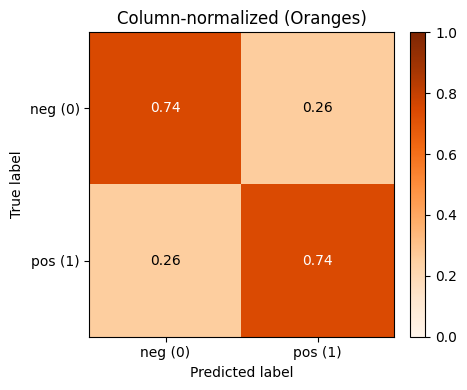

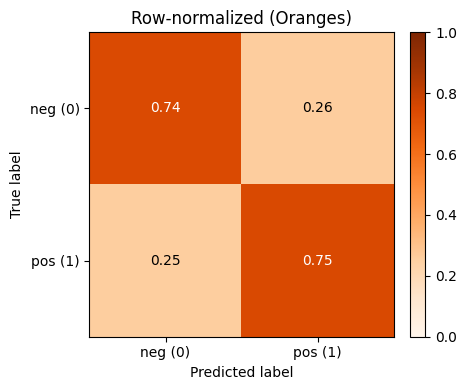

In [35]:
# Блок 3. Визуализация матрицы ошибок (heatmap) в тёплой палитре Oranges
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels=None,
    normalize: str | None = "col",   # None | "row" | "col" | "all"
    values_fmt: str | None = None,
    title: str = "Confusion matrix",
    cmap: str = "Oranges",
    vmin: float | None = None,
    vmax: float | None = None,
    show_colorbar: bool = True
):
    cm = confusion_matrix(y_true, y_pred).astype(float)

    if normalize is None:
        cm_to_show = cm;                values_fmt = values_fmt or ".0f"
    elif normalize == "row":
        cm_to_show = cm / cm.sum(axis=1, keepdims=True).clip(min=1.0); values_fmt = values_fmt or ".2f"; vmin = 0 if vmin is None else vmin; vmax = 1 if vmax is None else vmax
    elif normalize == "col":
        cm_to_show = cm / cm.sum(axis=0, keepdims=True).clip(min=1.0); values_fmt = values_fmt or ".2f"; vmin = 0 if vmin is None else vmin; vmax = 1 if vmax is None else vmax
    elif normalize == "all":
        cm_to_show = cm / cm.sum().clip(min=1.0);                      values_fmt = values_fmt or ".2f"; vmin = 0 if vmin is None else vmin; vmax = 1 if vmax is None else vmax
    else:
        raise ValueError("normalize must be None, 'row', 'col', or 'all'")

    labels = labels or [str(x) for x in np.unique(np.concatenate([y_true, y_pred]))]

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_to_show, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title); ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    if show_colorbar: fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    threshold_for_text = (cm_to_show.max() if vmax is None else vmax) / 2.0
    for i in range(cm_to_show.shape[0]):
        for j in range(cm_to_show.shape[1]):
            ax.text(j, i, format(cm_to_show[i, j], values_fmt),
                    ha="center", va="center",
                    color="white" if cm_to_show[i, j] > threshold_for_text else "black")
    ax.set_xlim(-0.5, cm_to_show.shape[1] - 0.5); ax.set_ylim(cm_to_show.shape[0] - 0.5, -0.5)
    ax.grid(False); plt.tight_layout(); plt.show()

# Нормировка по столбцам (Precision-ориентированная проекция) в палитре Oranges
plot_confusion_matrix(
    y_true=y_true_test, y_pred=y_pred_test,
    labels=["neg (0)", "pos (1)"],
    normalize="col", cmap="Oranges",
    title="Column-normalized (Oranges)"
)

# Дополнительно (по желанию): та же палитра, но нормировка по строкам
plot_confusion_matrix(
    y_true=y_true_test, y_pred=y_pred_test,
    labels=["neg (0)", "pos (1)"],
    normalize="row", cmap="Oranges",
    title="Row-normalized (Oranges)"
)


### Нормировки матрицы ошибок: в чём разница и как читать

**Row-normalized (нормировка по строкам)**  
- Каждая строка (фиксированный истинный класс) масштабируется так, чтобы сумма была 1.  
- Что показывают значения:
  - Диагональ — полнота (recall) по каждому классу: доля правильно распознанных объектов этого истинного класса.
  - Внедиагональные ячейки — доли ошибок внутри данного истинного класса: какая часть «ушла» в другой предсказанный класс.
- Удобно, когда интересует «как модель распознаёт каждый истинный класс» и где возникают пропуски.

**Column-normalized (нормировка по столбцам)**  
- Каждый столбец (фиксированный предсказанный класс) масштабируется так, чтобы сумма была 1.  
- Что показывают значения:
  - Диагональ — точность (precision) по каждому классу: доля действительно принадлежащих к этому классу среди всех так предсказанных.
  - Внедиагональные ячейки — «засорение» предсказанных классов чужими объектами (ложные срабатывания).
- Удобно, когда интересует «насколько чисты предсказанные классы» и где модель даёт лишние срабатывания.

**Почему на скриншоте значения почти одинаковые (например, 0.74/0.26)?**  
- Тестовый набор сбалансирован (примерно поровну объектов классов 0 и 1).  
- Ошибки модели симметричны: доли ложных срабатываний и пропусков похожи в обе стороны.  
- В такой ситуации доли по строкам и по столбцам оказываются близкими, поэтому обе нормировки выглядят почти одинаково.

**Когда различия будут заметны:**  
- При дисбалансе классов (например, 90/10): нормировки «row» и «col» дадут различную картину.  
- При смещении порога или асимметричных ошибках (модель чаще ошибается в одну сторону): «row» подсветит провалы по полноте, «col» — падение точности.

In [36]:
# Блок 4. Подбор порога на валидации (критерий: максимум F1)
import numpy as np
from sklearn.metrics import f1_score

threshold_grid = np.linspace(0.0, 1.0, 1001)
f1_on_val = [f1_score(validation_targets, (validation_probabilities >= thr).astype(int), zero_division=0)
             for thr in threshold_grid]
best_val_idx = int(np.argmax(f1_on_val))
BEST_THRESHOLD_BY_VAL_F1 = float(threshold_grid[best_val_idx])
print(f"[VAL] оптимальный порог по F1: {BEST_THRESHOLD_BY_VAL_F1:.3f} (F1={f1_on_val[best_val_idx]:.3f})")


[VAL] оптимальный порог по F1: 0.484 (F1=0.762)


### Блок 4 — подбор порога

Порог выбирается на валидации по целевой функции (здесь — максимум F1). В условиях сбалансированных классов F1 адекватно отражает компромисс «точность ↔ полнота». Выбранный порог далее переносится на тест.


In [37]:
# Блок 5. Сравнение на TEST: стандартный порог vs порог из валидации
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def summarize_at_threshold(y_true: np.ndarray, y_score: np.ndarray, thr: float, title: str):
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p   = precision_score(y_true, y_pred, zero_division=0)
    r   = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    print(f"{title:>18} | thr={thr:.3f} | Acc={acc:.3f}  P={p:.3f}  R={r:.3f}  F1={f1:.3f}")

summarize_at_threshold(y_true_test, y_score_test, DECISION_THRESHOLD,       "TEST @ default")
summarize_at_threshold(y_true_test, y_score_test, BEST_THRESHOLD_BY_VAL_F1, "TEST @ best F1(val)")


    TEST @ default | thr=0.500 | Acc=0.743  P=0.741  R=0.746  F1=0.743
TEST @ best F1(val) | thr=0.484 | Acc=0.738  P=0.713  R=0.799  F1=0.753


### Блок 5 — перенос порога на тест

Показывает влияние выбора порога на итоговые метрики. При сбалансированных классах оптимум по F1 обычно даёт разумный баланс точности и полноты.


In [38]:
# Построение матрицы ошибок после подбора порога (BEST_THRESHOLD_BY_VAL_F1)
# 1) бинaризация тестовых вероятностей новым порогом
y_pred_test_opt = (y_score_test >= BEST_THRESHOLD_BY_VAL_F1).astype(int)

# 2) быстрые метрики для контроля изменения
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"[TEST] при пороге из VAL (thr={BEST_THRESHOLD_BY_VAL_F1:.3f})")
print("  Accuracy :", accuracy_score(y_true_test, y_pred_test_opt))
print("  Precision:", precision_score(y_true_test, y_pred_test_opt, zero_division=0))
print("  Recall   :", recall_score(y_true_test, y_pred_test_opt, zero_division=0))
print("  F1       :", f1_score(y_true_test, y_pred_test_opt, zero_division=0))


[TEST] при пороге из VAL (thr=0.484)
  Accuracy : 0.73844
  Precision: 0.7127257155092427
  Recall   : 0.79888
  F1       : 0.7533476670061484


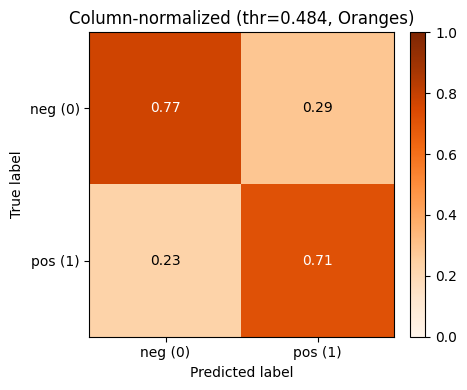

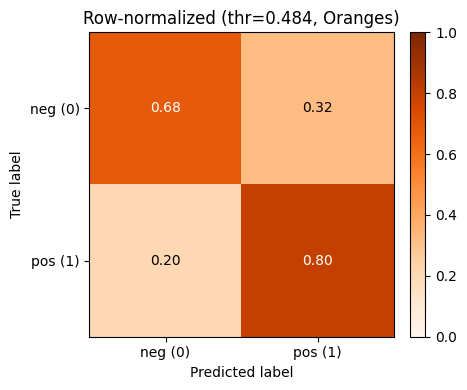

In [39]:
# Визуализация новой матрицы ошибок
# Используем ранее определённую функцию plot_confusion_matrix(...)

# column-normalized — «чистота» предсказанных классов (Precision-проекция)
plot_confusion_matrix(
    y_true=y_true_test, y_pred=y_pred_test_opt,
    labels=["neg (0)", "pos (1)"],
    normalize="col", cmap="Oranges",
    title=f"Column-normalized (thr={BEST_THRESHOLD_BY_VAL_F1:.3f}, Oranges)"
)

# row-normalized — полнота по истинным классам (Recall-проекция)
plot_confusion_matrix(
    y_true=y_true_test, y_pred=y_pred_test_opt,
    labels=["neg (0)", "pos (1)"],
    normalize="row", cmap="Oranges",
    title=f"Row-normalized (thr={BEST_THRESHOLD_BY_VAL_F1:.3f}, Oranges)"
)


### Чтение матриц после смены порога

- **Column-normalized**: диагональ показывает долю «верных внутри предсказанного класса» (точность по классам).  
  Сдвиг порога вверх обычно повышает точность класса 1 и понижает полноту; порог вниз — наоборот.
- **Row-normalized**: диагональ — доля «правильно найденных из данного истинного класса» (полнота по классам).  
  Сравнение с матрицами «до порога» показывает, какой тип ошибок вырос: FP (верхняя правая ячейка) или FN (нижняя левая).

**Замечания про баланс классов.**  
При 50/50 и симметричных ошибках обе нормировки могут оставаться визуально близкими. На несбалансированных наборах различия между `row` и `col` обычно выражены сильнее.


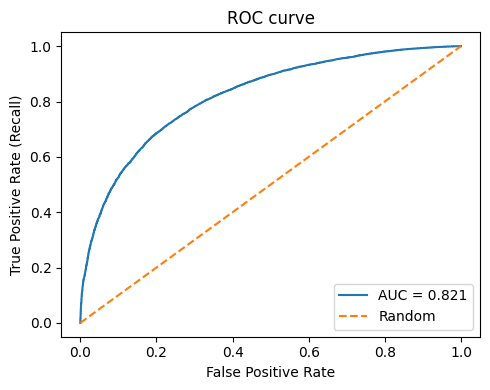

In [40]:
# Блок 6. ROC-кривая и AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_test, y_score_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()


### Интерпретация ROC-кривой

ROC-кривая отображает, как меняется полнота (True Positive Rate) при росте доли ложных срабатываний (False Positive Rate) при варьировании порога классификации.  
- Диагональ (пунктир) соответствует случайному угадыванию.  
- Чем дальше кривая отклоняется вверх-влево от диагонали, тем лучше модель различает классы.  
- Площадь под кривой (AUC) равна вероятности того, что случайно выбранный позитив будет оценён выше случайного негатива.  
- В данном случае AUC ≈ 0.82, что означает достаточно хорошее, но не идеальное качество ранжирования.


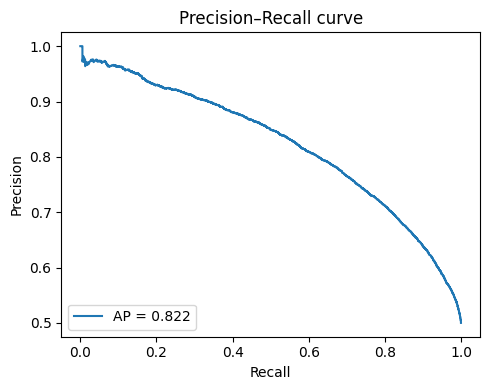

In [41]:
# Блок 7. PR-кривая и Average Precision
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_true_test, y_score_test)
ap = average_precision_score(y_true_test, y_score_test)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend(loc="lower left")
plt.tight_layout(); plt.show()


### Интерпретация PR-кривой

PR-кривая показывает соотношение точности (Precision) и полноты (Recall) при изменении порога классификации.  
- Высокая точность при низкой полноте означает, что модель уверенно выделяет лишь часть позитивов.  
- По мере роста полноты точность закономерно падает: чем больше найдено истинных объектов, тем больше появляется и ложных срабатываний.  
- Площадь под кривой (AP ≈ 0.82) отражает средний баланс между точностью и полнотой.  
- Чем выше кривая при данном уровне полноты, тем лучше модель. Значение около 0.82 указывает на достаточно хорошее качество предсказаний.


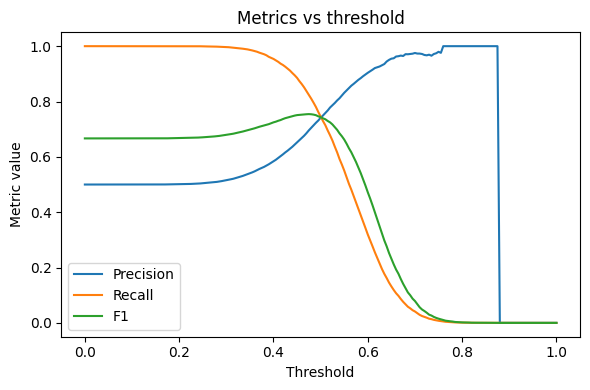

In [42]:
# Блок 8. Метрики как функция порога (Precision / Recall / F1)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

threshold_grid = np.linspace(0, 1, 201)
prec_vals, rec_vals, f1_vals = [], [], []
for thr in threshold_grid:
    y_pred = (y_score_test >= thr).astype(int)
    prec_vals.append(precision_score(y_true_test, y_pred, zero_division=0))
    rec_vals.append(recall_score(y_true_test, y_pred, zero_division=0))
    f1_vals.append(f1_score(y_true_test, y_pred, zero_division=0))

plt.figure(figsize=(6,4))
plt.plot(threshold_grid, prec_vals, label="Precision")
plt.plot(threshold_grid, rec_vals,  label="Recall")
plt.plot(threshold_grid, f1_vals,   label="F1")
plt.xlabel("Threshold"); plt.ylabel("Metric value")
plt.title("Metrics vs threshold")
plt.legend(); plt.tight_layout(); plt.show()


### Интерпретация графика "Metrics vs threshold"

На графике показано, как метрики Precision, Recall и F1 изменяются при сдвиге порога классификации:

- При низком пороге модель почти всё относит к классу 1 → Recall близок к 1 (позитивы почти не теряются), но Precision низкий (много ложных срабатываний).  
- При высоком пороге ситуация обратная: Precision стремится к 1 (ошибки почти исключены), но Recall падает к 0 (почти все позитивы пропущены).  
- F1-кривая достигает максимума в промежуточной области, где точность и полнота находятся в разумном балансе.  
- Такая визуализация помогает подобрать оптимальный порог под конкретные требования задачи (например, максимум F1 или приоритет Recall).
